In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np

from scipy import integrate

from astropy import constants as const
from astropy import units

/Users/egentry/anaconda/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


# Physics

In [2]:
M = const.M_earth.cgs.value
G = const.G.cgs.value
R = const.R_earth.cgs.value

def force(r_vector):
    """
    Calculates force per unit mass on a satellite in orbit around the earth.
    
    Assumes the earth is at the origin
    
    Parameters
    ----------
    r_vector : np.array (Nx2)
        position of satellite
        
    Returns
    -------
    f : np.array (Nx2)
        force per unit mass
    """
    r_scalar = np.sqrt((r_vector**2).sum())
    f_magnitude = G * M / r_scalar**3
    f = -(G * M / r_scalar**3) * r_vector
    return f

def dw_dt(w, t):
    x, y, v_x, v_y = w
    
    f = force(w[0:2])
    dw_dt = np.array([v_x, v_y, f[0], f[1]])
    
    return dw_dt
    

def energy(x, y, v_x, v_y):
    kinetic = 0.5 * ( v_x**2 + v_y**2 )
    r = np.sqrt(x**2 + y**2)
    potential = - G * M / r
    
    total = kinetic + potential
    return total

# Initial Conditions

In [3]:
r_0 = 1.1 * R
Omega_0 = np.sqrt(G * M / r_0**3)
v_0 = r_0 * Omega_0

P_0 = 2 * np.pi / Omega_0

w_0 = [r_0, 0, 0, v_0]

times = np.linspace(0, 10 * P_0, num=10000)



# Euler's Method

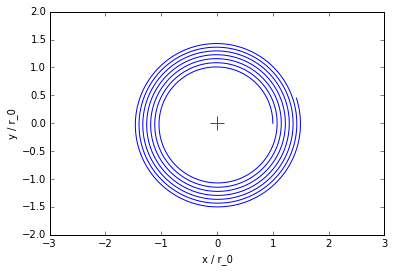

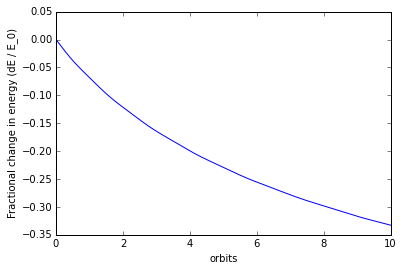

In [4]:
ws = np.empty((len(times), 4))


ws[0] = w_0

for i in range(len(times)-1):
    dt = times[i+1] - times[i]
    dw = dt * dw_dt(ws[i], times[i])
    ws[i+1] = ws[i] + dw
ws = ws.T
    

plt.plot(ws[0] / r_0, ws[1] / r_0)
plt.axis("equal")
plt.scatter(0,0, marker="+", s=200, color="r")
plt.xlabel("x / r_0")
plt.ylabel("y / r_0")


plt.figure()
energies = energy(ws[0], ws[1], ws[2], ws[3])
plt.plot(times / P_0, (energies / energies[0]) -1)
plt.xlabel("orbits")
plt.ylabel("Fractional change in energy (dE / E_0)")

# `odeint`


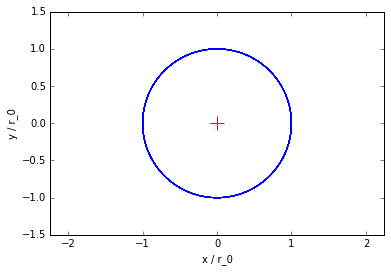

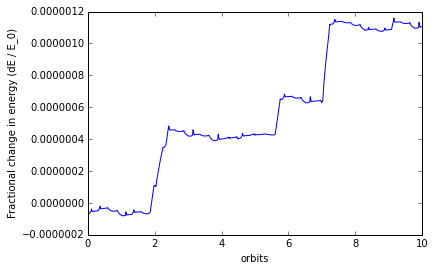

In [5]:
ws = integrate.odeint(dw_dt, w_0, times).T

plt.plot(ws[0] / r_0, ws[1] / r_0)
plt.axis("equal")
plt.scatter(0,0, marker="+", s=200, color="r")
plt.xlabel("x / r_0")
plt.ylabel("y / r_0")


plt.figure()
energies = energy(ws[0], ws[1], ws[2], ws[3])
plt.plot(times / P_0, (energies / energies[0]) - 1)
plt.xlabel("orbits")
plt.ylabel("Fractional change in energy (dE / E_0)")

# Lidov-Kozai

In [6]:
M_1 = 1   * const.M_sun.cgs.value
M_2 = .01 * const.M_sun.cgs.value
M_3 = 1   * const.M_sun.cgs.value


def force_3_body(w):
    r_1 = w[0:3]
    r_2 = w[6:9]
    r_3 = w[12:15]
    
    f_21 = G * M_2 * M_1 * (r_2 - r_1) / ((r_2 - r_1)**2).sum()**1.5
    
    f_31 = G * M_3 * M_1 * (r_3 - r_1) / ((r_3 - r_1)**2).sum()**1.5
    
    f_32 = G * M_3 * M_2 * (r_3 - r_2) / ((r_3 - r_2)**2).sum()**1.5
    
    f = np.empty(9)
    
    f[0:3] = ( f_21 + f_31) / M_1
    f[3:6] = (-f_21 + f_32) / M_2
    f[6:9] = (-f_31 - f_32) / M_3
    
    return f

def dw_dt_3_body(w, t):

    force = force_3_body(w)
    
    dw_dt = np.empty_like(w)
    
    dw_dt[ 0: 3] = w[3:6]
    dw_dt[ 3: 6] = force[0:3]
    dw_dt[ 6: 9] = w[9:12]
    dw_dt[ 9:12] = force[3:6]
    dw_dt[12:15] = w[15:18]
    dw_dt[15:18] = force[6:9]
    
    return dw_dt




times_3_body = np.linspace(0, 3000 * units.yr.to(units.s), num=1e5)

In [7]:
x_1 = 0
y_1 = 0
z_1 = 0
v_x_1 = 0
v_y_1 = 0
v_z_1 = 0

x_2 = 0
y_2 = .178 * units.AU.to(units.cm)
z_2 = .138 * units.AU.to(units.cm)
v_x_2 = 0
v_y_2 = -17.7 * units.AU.to(units.cm) / units.yr.to(units.s)
v_z_2 = 0

x_3 = 100 * units.AU.to(units.cm)
y_3 = 0
z_3 = 0
v_x_3 = 0
v_y_3 = 0.889 * units.AU.to(units.cm) / units.yr.to(units.s)
v_z_3 = 0

v_com_x = (M_1*v_x_1 + M_2*v_x_2 + M_3*v_x_3) / (M_1 + M_2 + M_3)
v_com_y = (M_1*v_y_1 + M_2*v_y_2 + M_3*v_y_3) / (M_1 + M_2 + M_3)
v_com_z = (M_1*v_z_1 + M_2*v_z_2 + M_3*v_z_3) / (M_1 + M_2 + M_3)

com_x = (M_1*x_1 + M_2*x_2 + M_3*x_3) / (M_1 + M_2 + M_3)
com_y = (M_1*y_1 + M_2*y_2 + M_3*y_3) / (M_1 + M_2 + M_3)
com_z = (M_1*z_1 + M_2*z_2 + M_3*z_3) / (M_1 + M_2 + M_3)

w_0 = np.array([x_1 - com_x, y_1 - com_y, z_1 - com_z, v_x_1 - v_com_x, v_y_1 - v_com_y, v_z_1 - v_com_z,
                x_2 - com_x, y_2 - com_y, z_2 - com_z, v_x_2 - v_com_x, v_y_2 - v_com_y, v_z_2 - v_com_z,
                x_3 - com_x, y_3 - com_y, z_3 - com_z, v_x_3 - v_com_x, v_y_3 - v_com_y, v_z_3 - v_com_z])

ws = integrate.odeint(dw_dt_3_body, w_0, times_3_body).T

In [8]:
def xy_plot(body):
    plt.plot(ws[0 + 6*(body-1)] / units.AU.to(units.cm),
             ws[1 + 6*(body-1)] / units.AU.to(units.cm))

    plt.xlabel("x [AU]")
    plt.ylabel("y [AU]")
    plt.axis("equal")
    

def yz_plot(body):
    plt.plot(ws[1 + 6*(body-1)] / units.AU.to(units.cm),
             ws[2 + 6*(body-1)] / units.AU.to(units.cm))

    plt.xlabel("x [AU]")
    plt.ylabel("y [AU]")
    plt.axis("equal")
    
    
def xz_plot(body):
    plt.plot(ws[1 + 6*(body-1)] / units.AU.to(units.cm),
             ws[2 + 6*(body-1)] / units.AU.to(units.cm))

    plt.xlabel("x [AU]")
    plt.ylabel("y [AU]")
    plt.axis("equal")

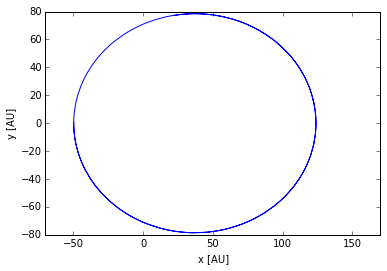

In [9]:
body = 1

xy_plot(body)

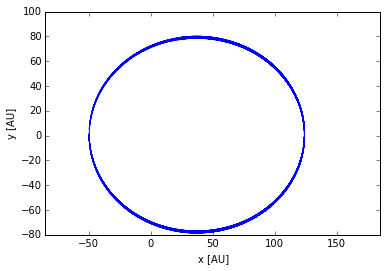

In [10]:
body = 2

xy_plot(body)

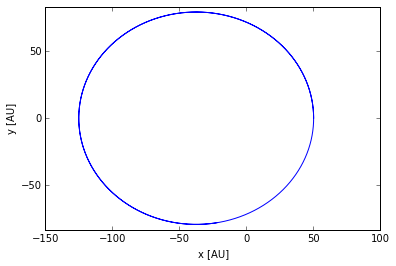

In [11]:
body = 3

xy_plot(body)